# Tarea Semanal N°9
#### Matías Blas Tassone

In [10]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from splane import plot_plantilla

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

La plantilla de diseño del filtro es la siguiente.

In [11]:
fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla

# filter design
ripple = 0.5 # dB
atenuacion = 30 # dB

ws1 = 0.1 #Hz
wp1 = 1 #Hz
wp2 = 38.0 #Hz
ws2 = 42.0 #Hz

ws1n = ws1/nyq_frec
wp1n = wp1/nyq_frec
wp2n = wp2/nyq_frec
ws2n = ws2/nyq_frec

Para el diseño del filtro IIR se utilizó la función iirdesign y para el filtro FIR se utilizó la función firls de la biblioteca de señales de Scipy.

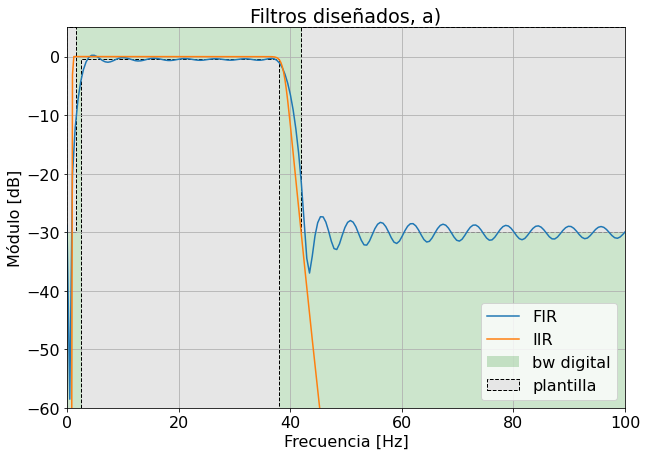

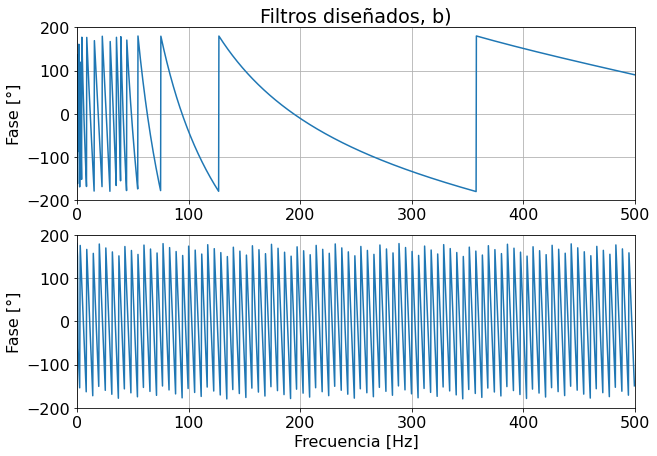

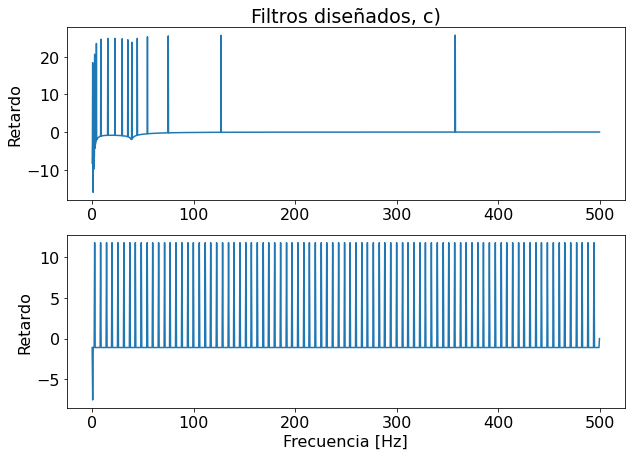

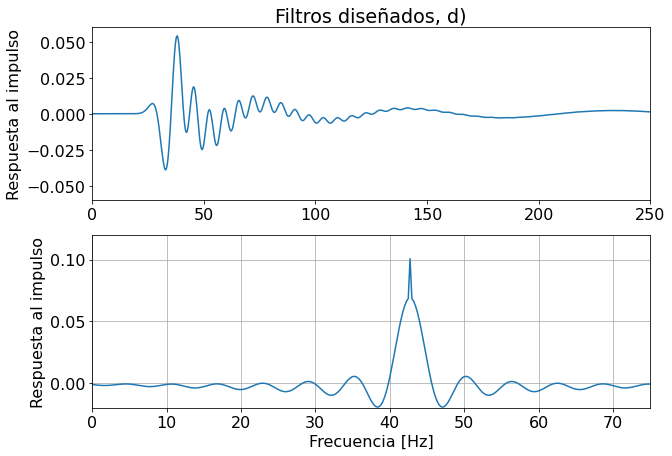

In [16]:
######################### Parte 1 ###################################

#IIR
bp_sos_butter = sig.iirdesign([wp1n, wp2n], [ws1n,ws2n], ripple, atenuacion, False, 'butter', 'sos')

#FIR

frecs = np.array([0.0, ws1+1.5, wp1+1.5, wp2, ws2, nyq_frec]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)
cant_coeficientes = 351
fir_firls = sig.firls(cant_coeficientes, frecs*nyq_frec, gains, fs=fs)

den = 1.0

#Plots

w, hh_win = sig.freqz(fir_firls, den, worN=1024)
Omega, H = sig.sosfreqz(bp_sos_butter, worN=2048, whole=False, fs=fs)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.figure()

plt.plot(w, 20 * np.log10(np.abs(hh_win)), label='FIR')
plt.plot(Omega, 20 * np.log10(np.abs(H)), label='IIR')

plt.title('Filtros diseñados, a)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.figure()
plt.subplot(211)
plt.title('Filtros diseñados, b)')
plt.plot(Omega, np.angle(H)*180/np.pi, label='IIR')
plt.ylabel('Fase [°]')
plt.grid()
plt.axis([0, nyq_frec, -200, 200 ]);
plt.subplot(212)
plt.plot(w, np.angle(hh_win)*180/np.pi, label='FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [°]')
plt.grid()
plt.axis([0, nyq_frec, -200, 200 ]);

ret1 = np.diff(np.angle(H))/np.diff(Omega)
ret1 = np.append(ret1,[0])
ret2 = np.diff(np.angle(hh_win))/np.diff(w)
ret2 = np.append(ret2,[0])

plt.figure()
plt.grid()
plt.subplot(211)
plt.title('Filtros diseñados, c)')
plt.ylabel('Retardo')
plt.plot(Omega, ret1, label='IIR')
plt.subplot(212)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Retardo')
plt.plot(w, ret2, label='FIR')


sig_in = [0] * 2047
sig_in = np.append(1, sig_in)

impulso1 = sig.sosfilt(bp_sos_butter, sig_in)
impulso2 = sig.lfilter(fir_firls, den, sig_in)

plt.figure()
plt.subplot(211)
plt.plot(Omega, impulso1, label='IIR')
plt.title('Filtros diseñados, d)')
plt.ylabel('Respuesta al impulso')
plt.axis([0, 250, -0.060, 0.060]);
plt.subplot(212)
plt.plot(Omega, impulso2, label='FIR')
plt.ylabel('Respuesta al impulso')
plt.xlabel('Frecuencia [Hz]')
plt.axis([0, 75, -0.02, 0.12]);
plt.grid()

Para la segunda parte, se aplican ambos filtros a la señal de ECG para ver su efecto.

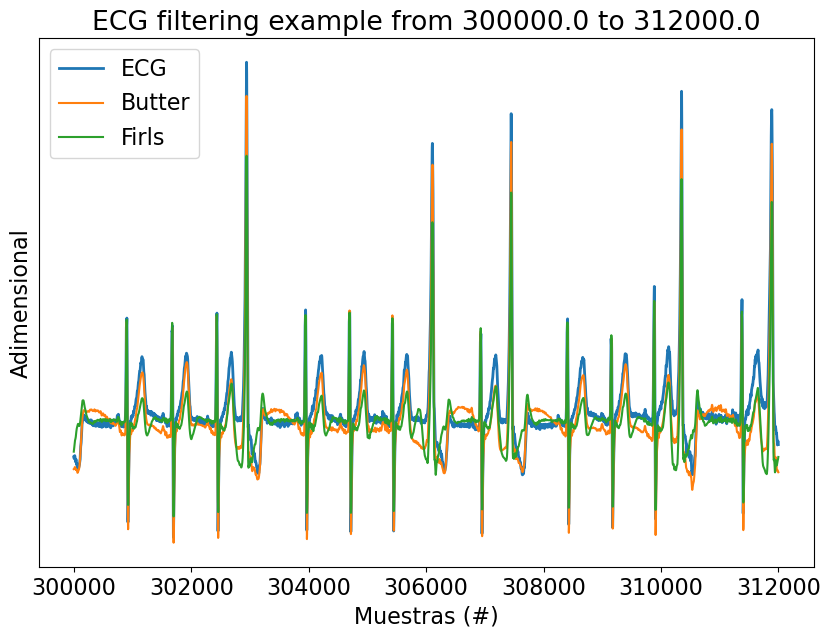

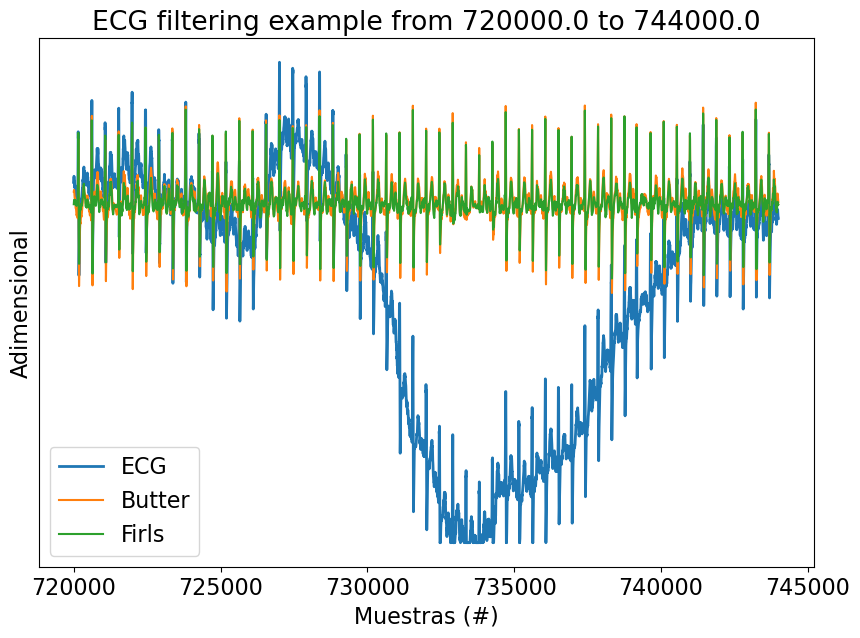

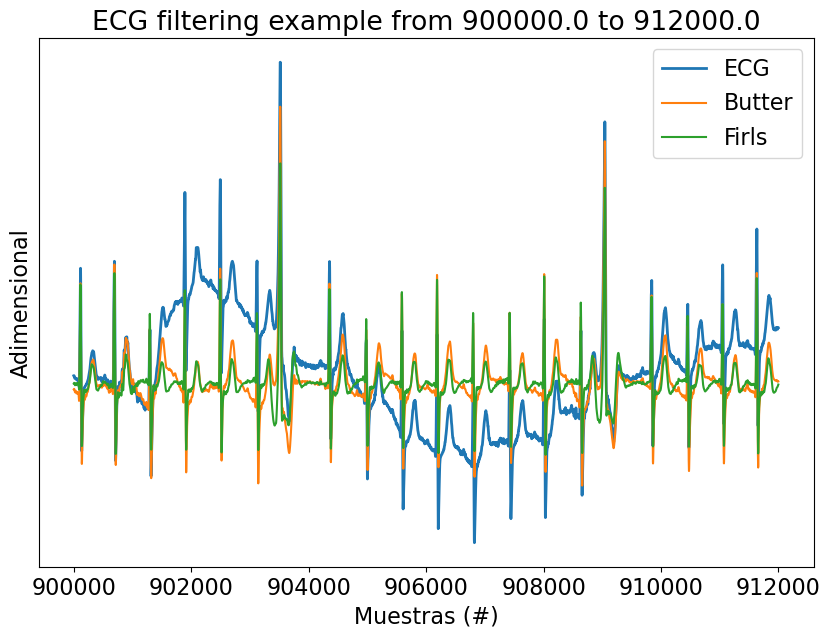

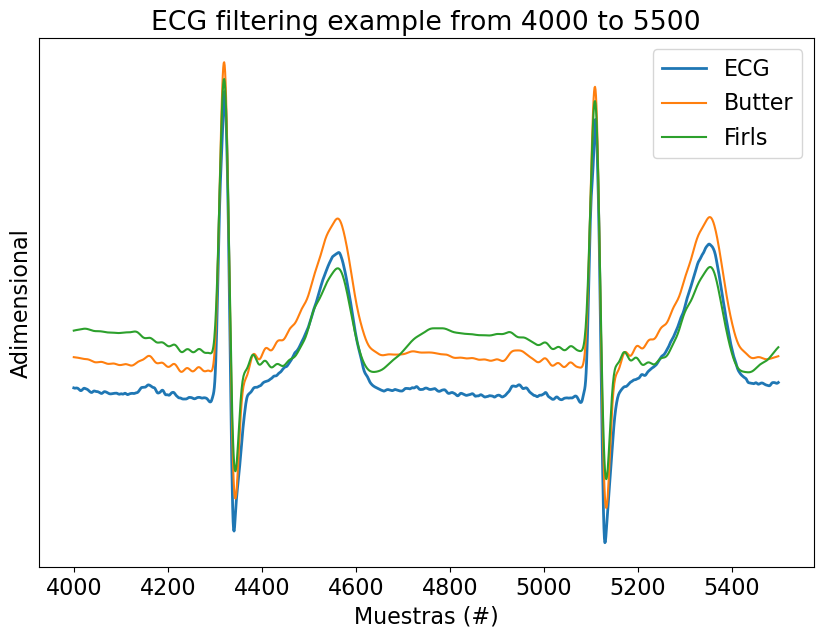

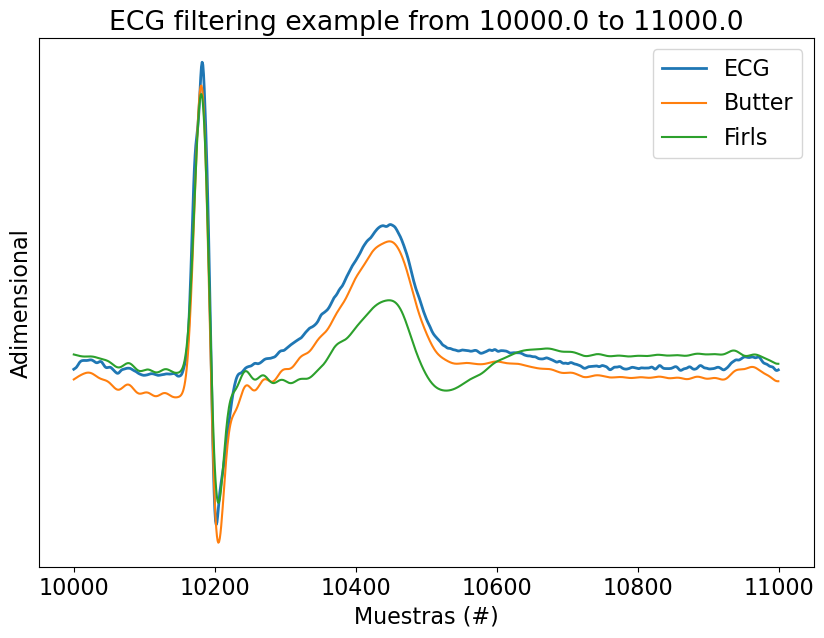

In [17]:
######################### Parte 2 ###################################

#IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)
ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

# FIR
#ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)
ECG_f_firls = sig.filtfilt(fir_firls, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_firls[zoom_region], label='Firls')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
             
    plt.show()
     
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_firls[zoom_region], label='Firls')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

En conclusión, el filtro IIR logra seguir mejor las bajas frecuencias, por lo que elegí aumentar las frecuencias de paso y de corte inferiores en el FIR. De todas formas, aunque las bajas frecuencias sean bien eliminadas por ambos filtros, el filtro FIR logra una respuesta más adecuada para la mayoría de las ventanas de los ejemplos, aunque ambos presenten distorsiones.